# Import Necessary Modules

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image as Image
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense 
from tensorflow.keras.optimizers import Adam

# Load the 'Simpsons Characters' Dataset
Download the Simpsons Characters dataset from https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset

## Create Data Generator Objects

In [2]:
# Create a Data Generator object for training dataset
train_datagen = Image.ImageDataGenerator(rotation_range=20,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         horizontal_flip=True,
                                         rescale=1./255)

# Create a Data Generator object for validation dataset
val_datagen = Image.ImageDataGenerator(rescale=1./255)

## Load the Training & Validation Datasets

In [3]:
batch_size = 32

# Load the training dataset
train_generator = train_datagen.flow_from_directory(
    directory='./Dataset/training/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

# Load the validation dataset
val_generator = val_datagen.flow_from_directory(
    directory='./Dataset/validation/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Store no of images present in training & validation datasets
nb_train_samples = train_generator.samples
nb_val_samples = val_generator.samples

Found 19548 images belonging to 20 classes.
Found 990 images belonging to 20 classes.


# Build a Model Using ResNet50V2

## Prepare a Base Model

In [4]:
# Load the ResNet50V2 model without the top layers
base_model = ResNet50V2(input_shape=(224, 224, 3),
                        include_top=False,
                        weights="imagenet")

# Freeze the base model
base_model.trainable = False
# Print a summary of the base model
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

## Construct the Head of the Model

In [5]:
# Initialize input of head_model as per the input of base_model
head_model = base_model.input
# Add the base_model & keep our batchnorm layers in inference mode when we unfreeze the base_model
head_model = base_model(head_model, training=False)
# Add a global average pooling layer
head_model = GlobalAveragePooling2D()(head_model)
# Add a dense/FC layer
head_model = Dense(1024, activation='relu')(head_model)
# Add a dense/FC layer
head_model = Dense(20, activation="softmax")(head_model)

## Build the Final Model

In [6]:
# Place the constructed head on top of the base model
model = Model(inputs=base_model.input, outputs=head_model)
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
# Print a summary of the base model                                                  
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 20)                20500     
Total params: 25,683,476
Trainable params: 2,118,676
Non-trainable params: 23,564,800
_________________________________________________________________


## Define Callbacks

In [7]:
# Define a callback for saving only the best model during the training
checkpoint = ModelCheckpoint(filepath="./Trained Models/simpsons_character_classifier.h5",
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

# Define a callback to stop training when validation accuracy has stopped increasing
earlystop = EarlyStopping(monitor='val_accuracy',
                          mode='max',
                          patience=5,
                          restore_best_weights=True,
                          verbose=1)

# Define a callback to reduce learning rate if validation accuracy has stopped increasing
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              mode='max')

# Put our callbacks into a list
callbacks = [earlystop, checkpoint, reduce_lr]

# Train the Head of the Model

In [8]:
# Train our the head of the model
model.fit(x=train_generator,
          epochs=30,
          callbacks=callbacks,
          steps_per_epoch=nb_train_samples // batch_size,
          validation_data=val_generator,
          validation_steps=nb_val_samples // batch_size)

Epoch 1/30
610/610 [==============================] - 290s 464ms/step - loss: 1.9629 - accuracy: 0.4409 - val_loss: 1.1558 - val_accuracy: 0.6635

Epoch 00001: val_accuracy improved from -inf to 0.66354, saving model to ./Trained Models\simpsons_character_classifier.h5
Epoch 2/30
610/610 [==============================] - 282s 462ms/step - loss: 1.1563 - accuracy: 0.6539 - val_loss: 0.9592 - val_accuracy: 0.7365

Epoch 00002: val_accuracy improved from 0.66354 to 0.73646, saving model to ./Trained Models\simpsons_character_classifier.h5
Epoch 3/30
610/610 [==============================] - 288s 472ms/step - loss: 0.9935 - accuracy: 0.6971 - val_loss: 0.8323 - val_accuracy: 0.7604

Epoch 00003: val_accuracy improved from 0.73646 to 0.76042, saving model to ./Trained Models\simpsons_character_classifier.h5
Epoch 4/30
610/610 [==============================] - 292s 478ms/step - loss: 0.9249 - accuracy: 0.7176 - val_loss: 0.7834 - val_accuracy: 0.7708

Epoch 00004: val_accuracy improved fr

# Perform Fine-Tuning

In [9]:
# Unfreeze the all the frozen layers in the model
model.trainable = True
# Compile the model again
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'])
# Print a summary of the model                                                  
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 20)                20500     
Total params: 25,683,476
Trainable params: 25,638,036
Non-trainable params: 45,440
_________________________________________________________________


In [10]:
# Fine tune our model and store the training results in a variable
model_train_result = model.fit(x=train_generator,
                               epochs=5,
                               callbacks=callbacks,
                               steps_per_epoch=nb_train_samples // batch_size,
                               validation_data=val_generator,
                               validation_steps=nb_val_samples // batch_size)

Epoch 1/5
610/610 [==============================] - 444s 719ms/step - loss: 0.2593 - accuracy: 0.9216 - val_loss: 0.2204 - val_accuracy: 0.9396

Epoch 00001: val_accuracy improved from 0.91146 to 0.93958, saving model to ./Trained Models\simpsons_character_classifier.h5
Epoch 2/5
610/610 [==============================] - 440s 721ms/step - loss: 0.1673 - accuracy: 0.9492 - val_loss: 0.1468 - val_accuracy: 0.9583

Epoch 00002: val_accuracy improved from 0.93958 to 0.95833, saving model to ./Trained Models\simpsons_character_classifier.h5
Epoch 3/5
610/610 [==============================] - 453s 743ms/step - loss: 0.1222 - accuracy: 0.9614 - val_loss: 0.1413 - val_accuracy: 0.9625

Epoch 00003: val_accuracy improved from 0.95833 to 0.96250, saving model to ./Trained Models\simpsons_character_classifier.h5
Epoch 4/5
610/610 [==============================] - 452s 740ms/step - loss: 0.1078 - accuracy: 0.9668 - val_loss: 0.1648 - val_accuracy: 0.9573

Epoch 00004: val_accuracy did not impr

# Evaluate Model's Performance

## Loss & Accuracy Charts

### Loss Chart

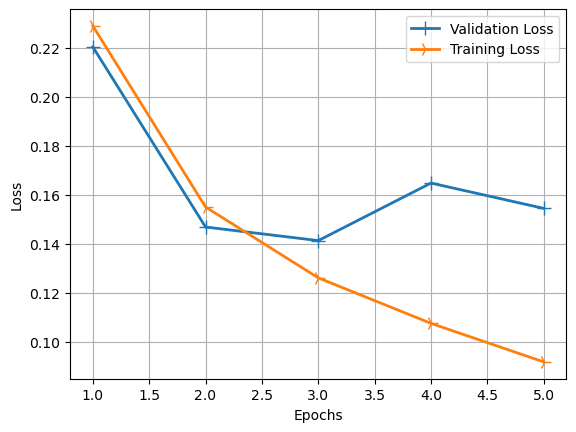

In [11]:
history_dict = model_train_result.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### Accuracy Chart

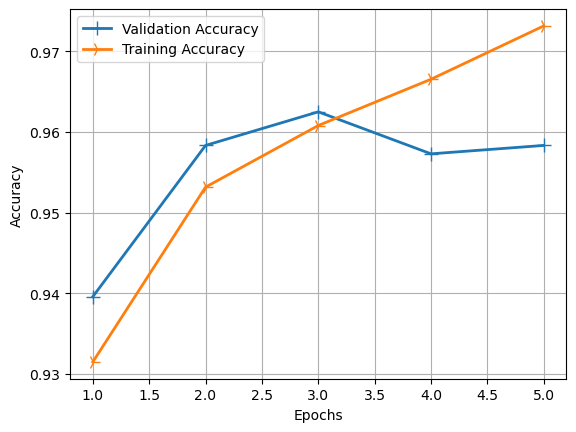

In [12]:
history_dict = model_train_result.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## Classification Report for Validation Dataset

In [13]:
# Get model's predictions for each image in val dataset
val_pred = model.predict(val_generator, nb_val_samples // batch_size + 1)
val_pred = np.argmax(val_pred, axis=1)

# Get class names
class_names = val_generator.class_indices
class_names = {v: k for k, v in class_names.items()}
class_names = list(class_names.values())

# Get the classification report generated for val dataset
print(classification_report(y_true=val_generator.classes,
                            y_pred=val_pred, target_names=class_names))

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.96      0.94      0.95        48
  apu_nahasapeemapetilon       0.94      0.98      0.96        50
            bart_simpson       0.98      0.98      0.98        50
charles_montgomery_burns       0.92      1.00      0.96        48
            chief_wiggum       0.93      1.00      0.96        50
          comic_book_guy       0.98      0.96      0.97        49
          edna_krabappel       0.96      0.92      0.94        50
           homer_simpson       0.87      0.96      0.91        50
           kent_brockman       1.00      0.96      0.98        50
        krusty_the_clown       0.98      0.98      0.98        50
           lenny_leonard       1.00      0.96      0.98        50
            lisa_simpson       0.94      1.00      0.97        50
           marge_simpson       1.00      0.98      0.99        50
            mayor_quimby       1.00      0.92      0.96        50
     milh

## Confusion Matrix for Validation Dataset

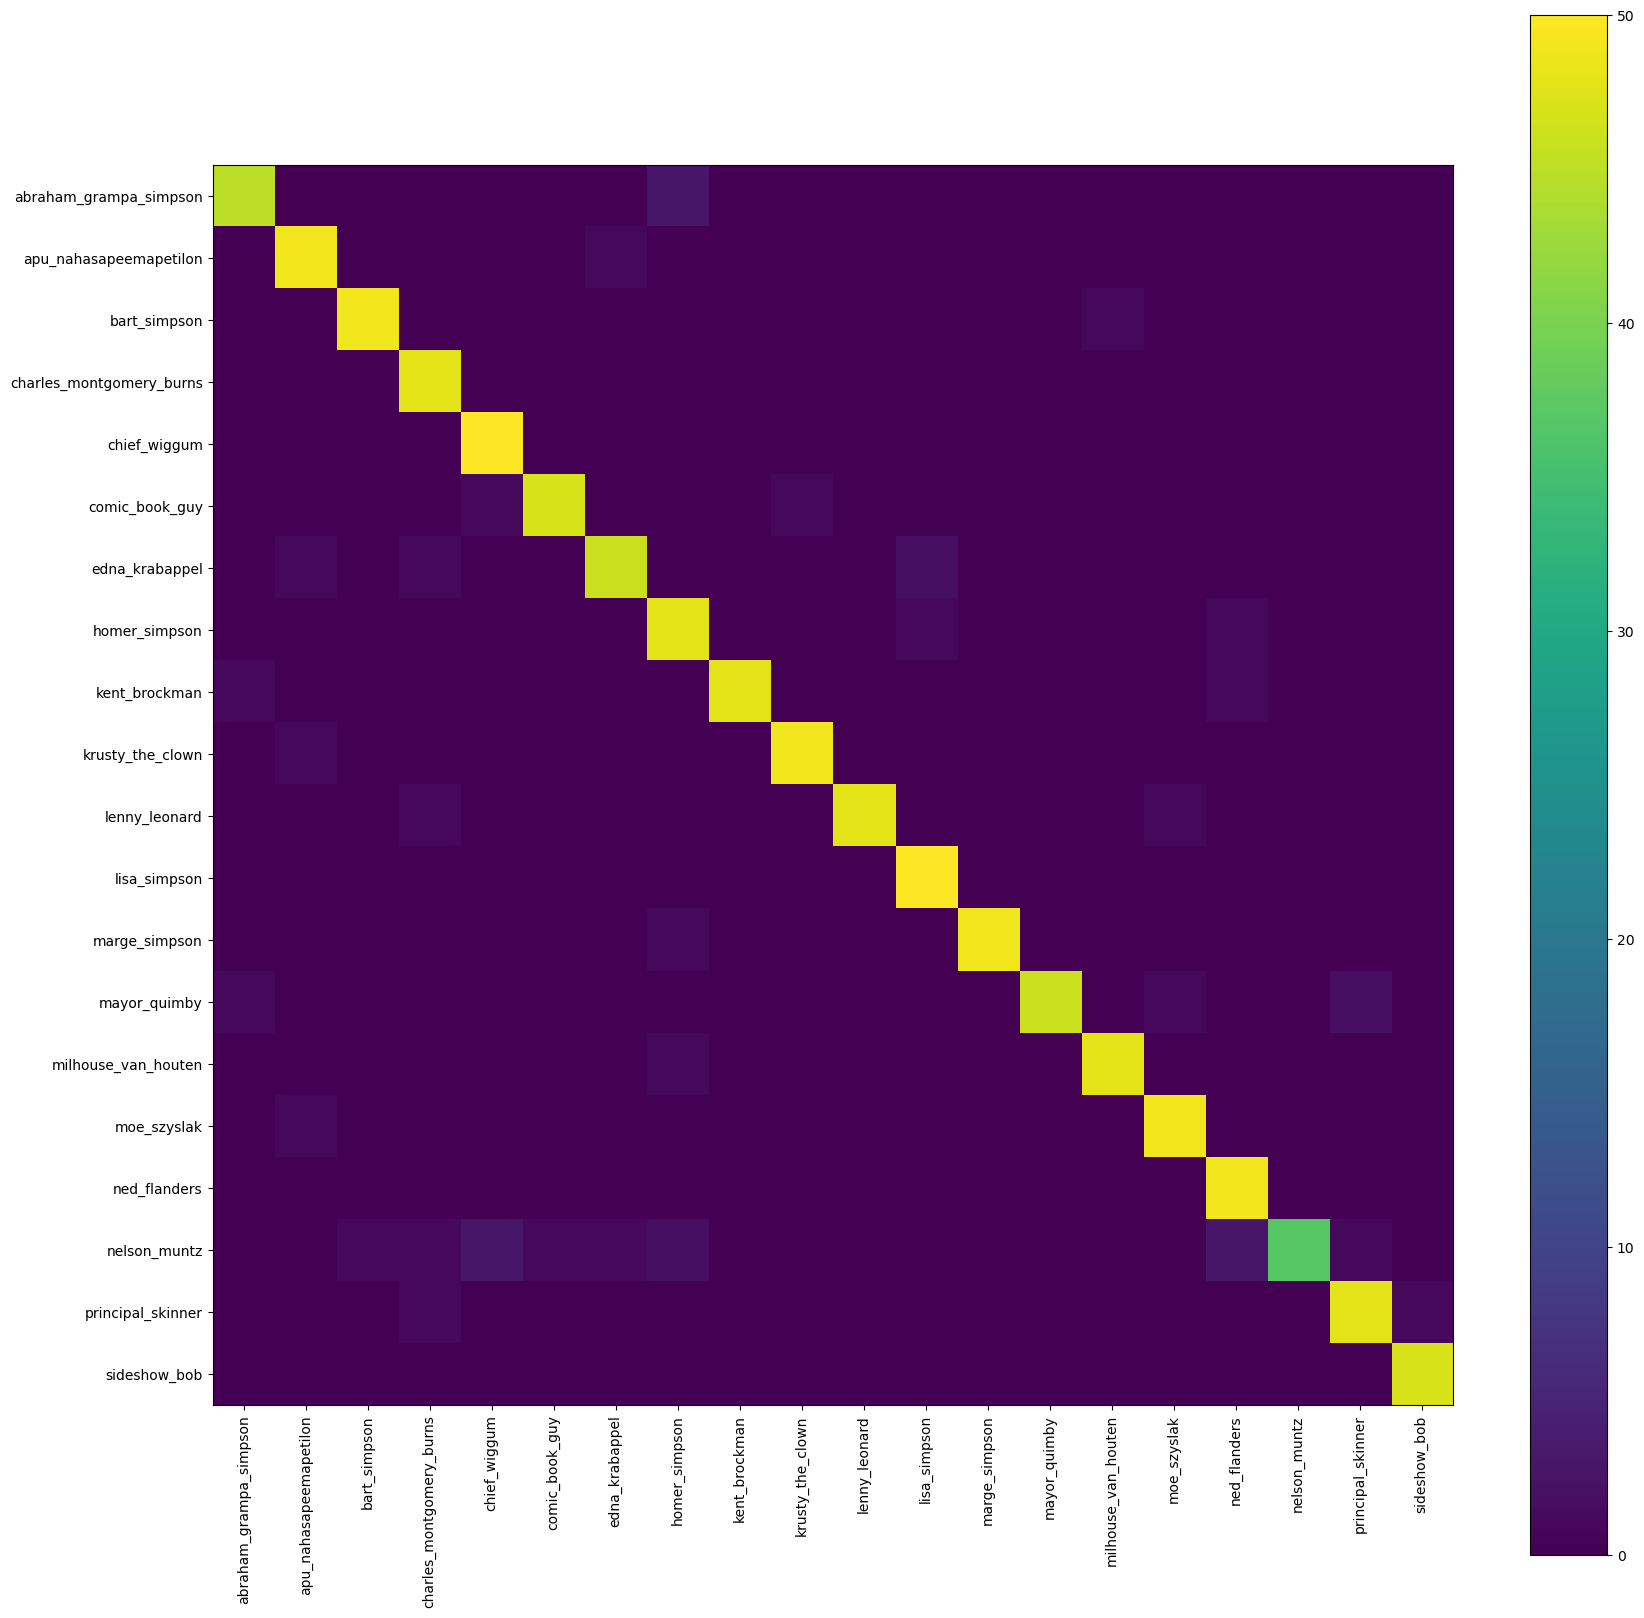

In [14]:
# Generate the confusion matrix for val dataset
cnf_matrix = confusion_matrix(y_true=val_generator.classes, y_pred=val_pred)

# Display the confusion matrix
plt.figure(figsize=(20, 20))
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(class_names))
_ = plt.xticks(tick_marks, class_names, rotation=90)
_ = plt.yticks(tick_marks, class_names)
plt.show()

# Classifier Demonstration

## Define Required Functions

In [15]:
# Define a function that grabs a random image from a random folder in the specified path
def get_random_image(path, img_width, img_height):
    folders = list(filter(lambda x: os.path.isdir(
        os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0, len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in os.listdir(
        file_path) if os.path.isfile(os.path.join(file_path, f))]
    random_file_index = np.random.randint(0, len(file_names))
    img_name = file_names[random_file_index]
    final_path = file_path + "/" + img_name
    img = Image.load_img(final_path, target_size=(img_width, img_height))
    return img, final_path, path_class


# Define a function that will draw class name, model's prediction & true label over the input image
def draw_test(name, pred, img, true_label):
    expanded_img = cv2.copyMakeBorder(
        img, 160, 0, 0, 500, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    cv2.putText(expanded_img, "predicted - " + pred, (20, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.putText(expanded_img, "true - " + true_label, (20, 120),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow(name, expanded_img)

## Run the Demonstration

In [16]:
path = './Dataset/Validation/'
files = []
predictions = []
true_labels = []

for i in range(0, 10):
    img, final_path, true_label = get_random_image(path, 224, 224)
    files.append(final_path)
    true_labels.append(true_label)
    x = Image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = np.argmax(model.predict(x), axis=-1)
    predictions.append(classes)

for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_test("Simpsons Character Classifier - Demo",
              class_names[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()